# Ensemble methods in ML

https://bit.ly/2ljCyNW

Import the key modules

In [1]:
import zipfile

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

Fix the random state

In [2]:
random_state = np.random.RandomState(0x5A17F00D)

## Boostrapping

<!--
Bootstrapping is a simple statistical technique to measure the sampling
distribution of almost any estimation procedure.
-->

A train sample $S = (z_i)_{i=1}^m \in \mathcal{Z}$ iid from $D$.

A bootstrap sample $S^*_b = (z^*_i)_{i=1}^l$ is an iid sample from the **empirical
distribution** induced by $S$.

Each bootstrap rv $z^*_i$ is conditioned by  $S$ and defined as
$$ z^*_i = \biggl\{ z_j \text{ with prob. } \frac{1}{n}\,,\, j=1, \ldots, n\bigr.\,. $$

**``GetBootstrapSample(S, l)``**:
* let $S^*$ be the empty list;
* for $i=1, \ldots, l$:
    * pick an independent random $j$ from $1..m$;
    * **copy** the $j$-th element of $S$ into $S^*$;
* return $S^*$.

## Bagging

1. generate many bootstrap samples
2. learn an estimator on each one
3. aggregate!

Works best:
* the base models are non-linear or highly data-sensitive
* the pooled estimators are uncorrelated;
then the bagging estimator has much reduced variance, while retaining low bias

On average $36.79\%$ of $S$ **do not appear** in a bootstrap sample $S^*$.
* can the **out-of-bag** samples for validation!

### Bagged Regression
$\hat{f}:\mathcal{X} \mapsto\mathbb{R}$ -- a regression function learnt on $S$.

* Regression Tree
* kernel ridge regression
* support vector regression
* $k$-NN regression
* multi-layer neural network with nonlinear hidden layers

**`BaggedRegression(`$\mathcal{A}$, $S$, $\eta$`)`**:

1. For each $b=1,\ldots,B$ do:
    * Draw an **independent** sample $S^{*b}$ of size $\lfloor\eta m\rfloor$;
    * Learn an estimator $\hat{f}^{*b}$ by fitting to $S^{*b}$;
2. Construct the bagged estimator by averaging:
$$ \hat{f}^{\texttt{bag}}_B(x)
        = B^{-1} \sum_{b=1}^B \hat{f}^{*b}(x)
    \,; $$
3. return $\hat{f}^{\texttt{bag}}_B(\cdot)$.

### Bagged Classification
$\hat{f}:\mathcal{X} \mapsto\mathbb{R}^K$
a class scoring function learnt on $S$.

* Classification Tree
* support vector classifier
* $k$-NN
* multi-layer classifying NN

**`BaggedClassifier(`$S$, $\eta$`)`**:

1. For each $b=1,\ldots,B$ do:
    * Draw an **independent** sample $S^{*b}$ of size $\lfloor\eta m\rfloor$;
    * Learn a class-scoring function $\hat{f}^{*b}$ from $S^{*b}$;
2. Construct the **Majority Vote** classifier:
$$ \hat{f}^{\texttt{bag}}_B(x)
        = \mathtt{MAJ}\bigl( B^{-1}\sum_{b=1}^B \hat{f}^{*b}(x) \bigr)
        \,,\,\,\,
        \mathtt{MAJ}(w) = \mathop{\text{argmax}}_{k=1,\ldots, K} w_k
  \,; $$
3. return $\hat{f}^{\texttt{bag}}_B(\cdot)$.

### Bagging in SciKit

`sklearn.ensemble` module has two bagging meta-estimators:
* highly flexible and parallelized
* capable of doing both sample-space bootstrapping and feature-space sampling

In [3]:
from sklearn.ensemble import BaggingRegressor, BaggingClassifier

* **`BaggingClassifier`** --
> fits base classifiers each on random subsets of the original dataset and then aggregates their individual predictions by voting to form a final prediction

* **`BaggingRegressor`** -- 
> fits base regressors each on random subsets of the original dataset and then averages their individual predictions
to form a final prediction

Both meta-estimators have similar parameters

- **n_estimators** -- the number of estimators in the ensemble
- **base_estimator** -- the base estimator from which the bagged ensemble is built
- **random_state** -- controls the source of randomness during bagging
- **bootstrap** -- determines whether samples are drawn with replacement
- **bootstrap_features** -- determines whether features are drawn with replacement

- **max_samples** -- the fraction of samples to be used to train each base estimator
- **max_features** -- The number of features to draw from X to train each base estimator
- **oob_score** -- determines whether to use **out-of-bag** samples to estimate
    the generalization error;

### Toy Data

In [4]:
def f(X):
    X = X.ravel()
    return np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2)

def generate(n_samples, random_state, n_repeat=1):
    X = np.sort(random_state.uniform(-5, 5, size=n_samples))
    y = f(X).reshape(-1, 1)
    y += random_state.normal(0.0, 0.1, size=(n_samples, n_repeat))
    return X.reshape(-1, 1), y if n_repeat > 1 else y.reshape(-1)

In [5]:
n_train, n_test = 200, 1000

X_train, y_train = generate(n_train, random_state)
X_test, y_test = generate(n_test, random_state)

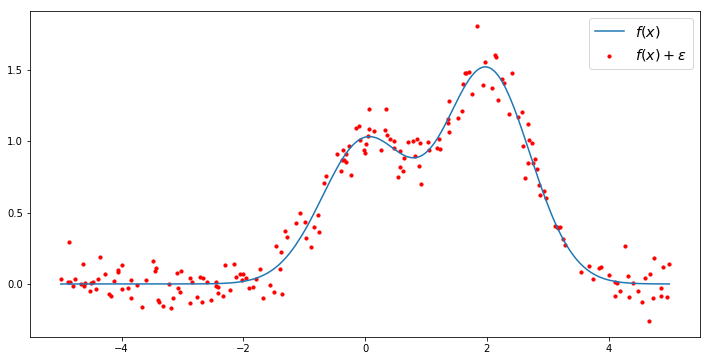

In [6]:
ax = plt.figure(figsize=(12, 6)).add_subplot(111)

ax.scatter(X_train, y_train, c="r", s=10, label="$f(x) + \epsilon$")
ax.plot(X_test, f(X_test), label="$f(x)$")

ax.legend(fontsize="x-large");

In [7]:
regBag = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(),
    n_estimators=150,
    random_state=123)

regBag.fit(X_train, y_train);

Fit a bagged regression and plot individual regression trees

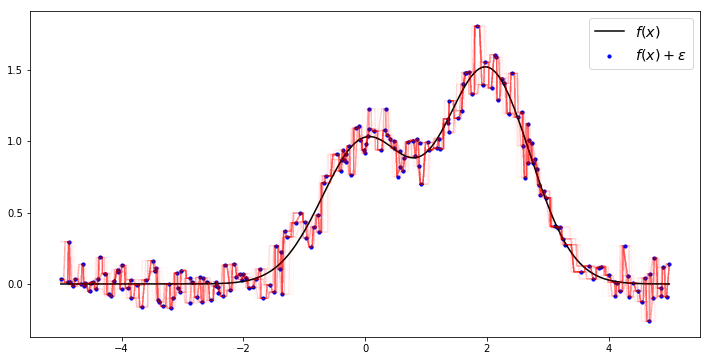

In [8]:
ax = plt.figure(figsize=(12, 6)).add_subplot(111)

ax.scatter(X_train, y_train, c="blue", s=10, label="$f(x) + \epsilon$")
ax.plot(X_test, f(X_test), c="black", label="$f(x)$")
for reg_ in regBag.estimators_:
    ax.plot(X_test, reg_.predict(X_test), "red", alpha=0.01, zorder=+99)

ax.legend(fontsize="x-large");

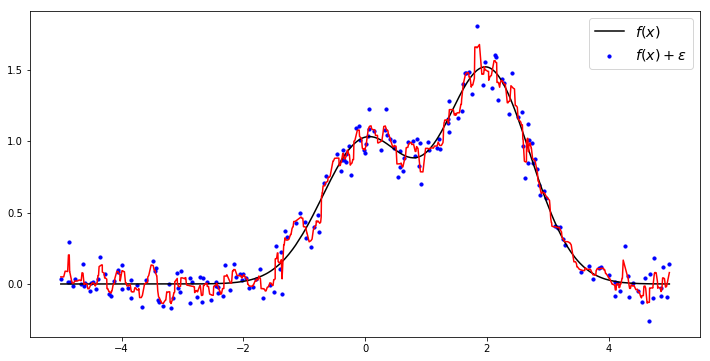

In [9]:
ax = plt.figure(figsize=(12, 6)).add_subplot(111)

ax.scatter(X_train, y_train, c="blue", s=10, label="$f(x) + \epsilon$")
ax.plot(X_test, f(X_test), c="black", label="$f(x)$")
ax.plot(X_test, regBag.predict(X_test), "red", alpha=1.0, zorder=+99)

ax.legend(fontsize="x-large");

The effect of the subsampling fraction and the number of estimators

In [10]:
parameters = ParameterGrid(dict(max_samples=[0.25, 0.75],
                                n_estimators=[25, 250]))

# Construct and fit regressors
regressors = [BaggingRegressor(DecisionTreeRegressor(),
                               random_state=123,
                               **par_).fit(X_train, y_train)
              for par_ in parameters]

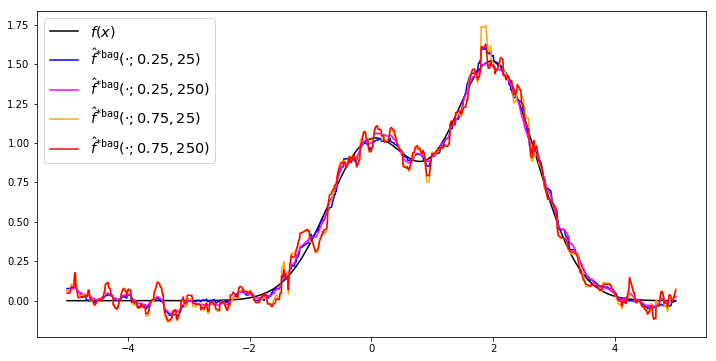

In [11]:
ax = plt.figure(figsize=(12, 6)).add_subplot(111)
ax.plot(X_test, f(X_test), c="black", label="$f(x)$")
for reg_, color_ in zip(regressors, ["blue", "magenta", "orange", "red"]):
    name_ = "$\\hat{f}^{*\\mathtt{bag}}(\\cdot; %0.2f, %d)$"%(
        reg_.max_samples, reg_.n_estimators)
    ax.plot(X_test, reg_.predict(X_test), color=color_, label=name_)
ax.legend(fontsize="x-large");

Estimate the effect of the sub-sampling fraction on the the bias and variance of Bagged Regression Trees.

In [12]:
# Generate a lot of train samples
n_repeat = 16 # 51
samples = [generate(n_train, random_state) for i in range(n_repeat)]

# Create a bunch of bagging regressors
max_samples = np.linspace(0, 1, num=51)[1:]
regressors = [BaggingRegressor(DecisionTreeRegressor(),
                               n_estimators=50, max_samples=frac_,
                               random_state=123)
              for frac_ in max_samples]

def do_bias_variance(regressor):
    # fit on each train and predict on the fixed test
    y_pred_ = np.stack([regressor.fit(X_, y_).predict(X_test)
                        for X_, y_ in samples], axis=-1)
    ## Bias and variance
    return np.mean((f(X_test) - y_pred_.mean(axis=-1))**2), \
           y_pred_.var(axis=-1).mean()

Let's do the estimation in parallel.

In [13]:
from joblib import Parallel, delayed

with Parallel(n_jobs=-1) as parallel:
    results = parallel(delayed(do_bias_variance)(reg_)
                       for reg_ in regressors)

bias_ = np.asarray([ret_[0] for ret_ in results])
variance_ = np.asarray([ret_[1] for ret_ in results])

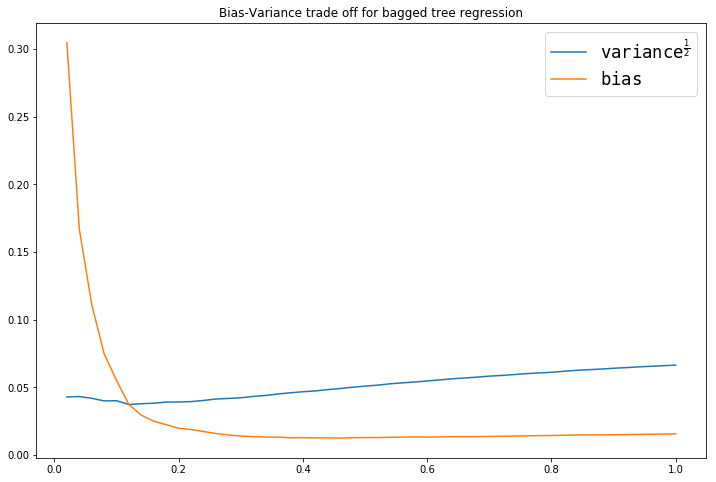

In [14]:
ax = plt.figure(figsize=(12, 8)).add_subplot(111)
ax.plot(max_samples, np.sqrt(variance_), label="$\\mathtt{variance}^\\frac{1}{2}$")
ax.plot(max_samples, np.sqrt(bias_), label="$\\mathtt{bias}$")
ax.set_title("Bias-Variance trade off for bagged tree regression")
ax.legend(fontsize="xx-large");

In [15]:
best_max_samples = max_samples[(bias_ + variance_).argmin()]
print("the best sub-sampling share is %0.2f"%(best_max_samples,))

the best sub-sampling share is 0.22


In [16]:
regBag = BaggingRegressor(DecisionTreeRegressor(), n_estimators=50,
                          max_samples=best_max_samples)
regBag.fit(X_train, y_train);

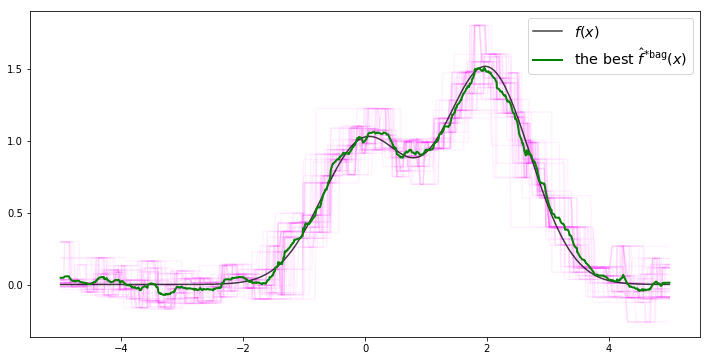

In [17]:
ax = plt.figure(figsize=(12, 6)).add_subplot(111)
ax.plot(X_test, f(X_test), c="black", label="$f(x)$", alpha=0.75)
for reg_ in regBag.estimators_:
    ax.plot(X_test, reg_.predict(X_test), "magenta",
            alpha=0.05, zorder=-99)
ax.plot(X_test, regBag.predict(X_test), "green", lw=2,
        alpha=1.0, zorder=+99, label="the best $\\hat{f}^{*\\mathtt{bag}}(x)$")
ax.legend(fontsize="x-large");

Let's inspect the effects of the size of the ensemble.

In [18]:
# Create a bunch of bagging regressors
n_estimators = np.arange(1, 211, 7)
regressors = [BaggingRegressor(DecisionTreeRegressor(),
                               max_samples=best_max_samples,
                               n_estimators=n_estimators_)
              for n_estimators_ in n_estimators]

In [19]:
with Parallel(n_jobs=-1) as parallel:
    results = parallel(delayed(do_bias_variance)(reg_)
                       for reg_ in regressors)

bias_ = np.asarray([ret_[0] for ret_ in results])
variance_ = np.asarray([ret_[1] for ret_ in results])

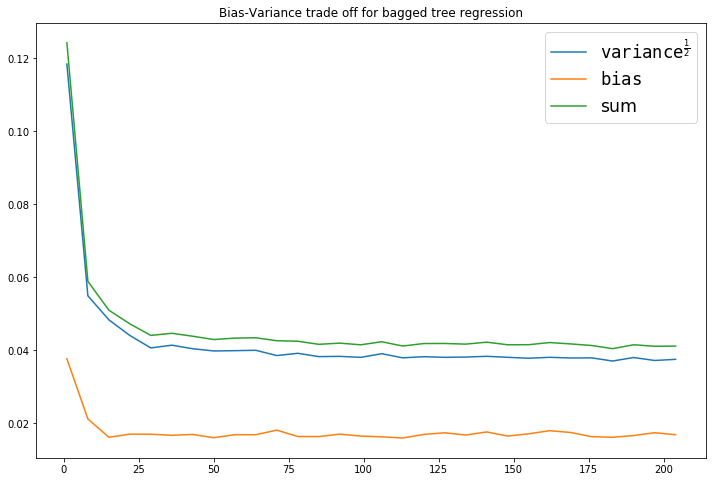

In [20]:
ax = plt.figure(figsize=(12, 8)).add_subplot(111)
ax.plot(n_estimators, np.sqrt(variance_), label="$\\mathtt{variance}^\\frac{1}{2}$")
ax.plot(n_estimators, np.sqrt(bias_), label="$\\mathtt{bias}$")
ax.plot(n_estimators, np.sqrt(variance_ + bias_), label="sum")
ax.set_title("Bias-Variance trade off for bagged tree regression")
ax.legend(fontsize="xx-large");

In [21]:
best_n_estimators = n_estimators[(bias_ + variance_).argmin()]
print("the best size of the ensemble is %d"%(best_n_estimators,))

the best size of the ensemble is 183


In [22]:
regBag = BaggingRegressor(DecisionTreeRegressor(),
                          n_estimators=best_n_estimators,
                          max_samples=best_max_samples)
regBag.fit(X_train, y_train);

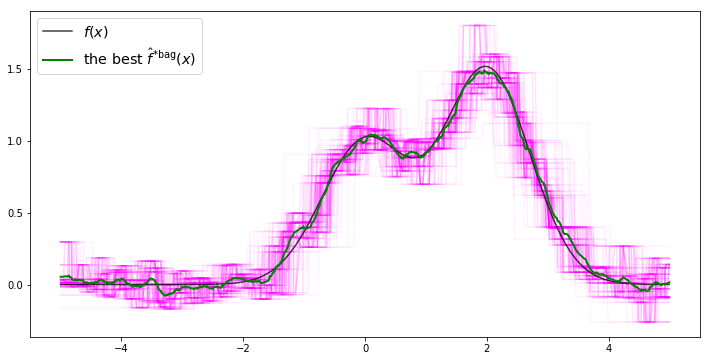

In [23]:
ax = plt.figure(figsize=(12, 6)).add_subplot(111)
ax.plot(X_test, f(X_test), c="black", label="$f(x)$", alpha=0.75)
for reg_ in regBag.estimators_:
    ax.plot(X_test, reg_.predict(X_test), "magenta",
            alpha=0.05, zorder=-99)
ax.plot(X_test, regBag.predict(X_test), "green", lw=2,
        alpha=1.0, zorder=+99, label="the best $\\hat{f}^{*\\mathtt{bag}}(x)$")
ax.legend(fontsize="x-large");

## Random Forest

The Random Forest is a bagging ensemble constructed from a large collection
of **decorrelated** regression/decision trees.

The bagging algorithm uses specialized tree induction procedure to produce
trees with low correlation:

**`RandomForest(`$S$, $\eta$, $\theta$`)`**

1. for $b=1,\ldots, B$ do:
    1. Draw a bootstrap sample $S^{*b}$, of size $P = \lfloor \eta n\rfloor$ from $S$;
    2. Greedily grow a tree $T^{*b}$ using special decorrelation heuristics:
        * feature for the tree split are chosen from a **fraction** $\theta$
          of the feature picked randomly;
        * the tree is grown until a minimum node size is reached;
2. Return the bagged tree ensemble  $\bigl(\hat{T}^{*b}\bigr)_{b=1}^B$;

### Random Forest in SciKit

`sklearn.ensemble` module has two Random Forest ensembles
* unlike Bagging, the size of bootstrap samples is fixed to the size of $S$
* otherwose both are flexible and parallelized

In [24]:
from sklearn.ensemble import RandomForestClassifier, \
                             RandomForestRegressor

* **`RandomForestClassifier`** --
> fits a number of decision tree classifiers on various sub-samples of the dataset and
uses voting to improve the predictive accuracy and control over-fitting.

* **`RandomForestRegressor`** --
> fits a number of classifying decision trees on various sub-samples of
the dataset and uses averaging to improve the predictive accuracy and control
over-fitting.

Random Forest Classifier and Regressor accept similar parameters:

Ensemble parameters:
- **max_features** -- The number of features to consider when looking for the
best split: `sqrt`, `log2` and share in $(0,1]$ are accepted (choosing `max_features < n_features`
leads to a reduction of variance and an increase in bias);
- **bootstrap** -- determines whether samples are drawn with replacement;
- **oob_score** -- determines whether to use out-of-bag samples to estimate
    the generalization error;

Parameters governing the tree growth:
- **criterion** -- the criterion to control the tree growing process:
    * Classification:
        * _"gini"_ -- Gini impurity (classification only);
        * _"entropy"_ -- the information gain (classification only);
        * _"mse"_ -- mean squared error (regression only);
    * Regression:
        * _'mse'_ -- the Mean Squared Error, (variance reduction);
        * _'mae'_ -- the Mean Absolute Error;

- **max_depth** -- maximum depth of the individual regression tree estimators
(the maximum depth limits the number of nodes in the tree, the best value depends
on the interaction of the input variables);
- **min_samples_leaf** -- The minimum number of samples required to be at a
leaf node;
- **min_weight_fraction_leaf** -- The minimum weighted fraction of the input
samples required to be at a leaf node;

- **max_leaf_nodes** -- Grow trees with ``max_leaf_nodes`` in best-first
fashion, determined by the relative reduction in impurity;
- **min_samples_split** -- The minimum number of samples required to split an
internal node;
- **min_impurity_split** -- Threshold for early stopping in tree growth.

Produce some toy sample data

In [25]:
def scikit_example(n_samples, random_state=None):
    X1, y1 = make_gaussian_quantiles(cov=2., n_samples=int(0.4*n_samples),
                                     n_features=2, n_classes=2,
                                     random_state=random_state)
    X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                     n_samples=int(0.6*n_samples),
                                     n_features=2, n_classes=2,
                                     random_state=random_state)
    return np.concatenate((X1, X2)), np.concatenate((y1, 1 - y2))

Get a train set, a test set, and a $2$-d mesh for plotting.

In [26]:
X, y = scikit_example(n_samples=500, random_state=random_state)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, random_state=random_state)

min_, max_ = np.min(X, axis=0) - 1, np.max(X, axis=0) + 1
xx, yy = np.meshgrid(np.linspace(min_[0], max_[0], num=51),
                     np.linspace(min_[1], max_[1], num=51))

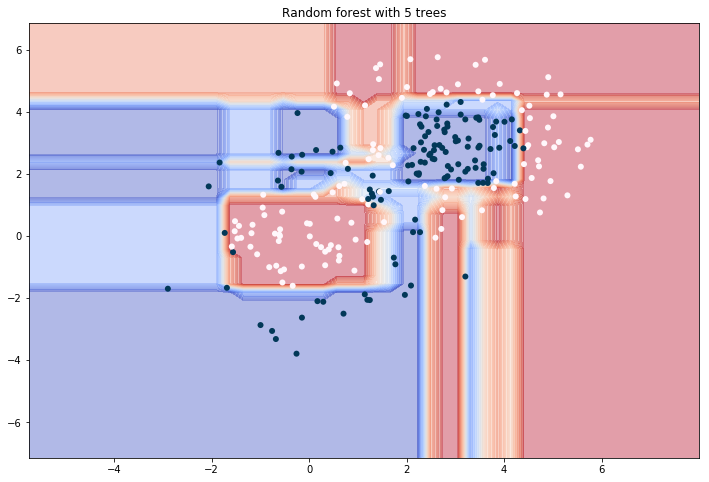

In [27]:
rf5_ = RandomForestClassifier(n_estimators=5, random_state=0x1234)
rf5_.fit(X_train, y_train)

ax = plt.figure(figsize=(12, 8)).add_subplot(111)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
           cmap=plt.cm.PuBu, lw=0, zorder=+99)
prob_ = rf5_.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
ax.contourf(xx, yy, prob_, alpha=0.4, cmap=plt.cm.coolwarm_r,
            levels=np.linspace(0,1, num=51), lw=0)
ax.set_title("Random forest with %d trees"%(rf5_.n_estimators,));

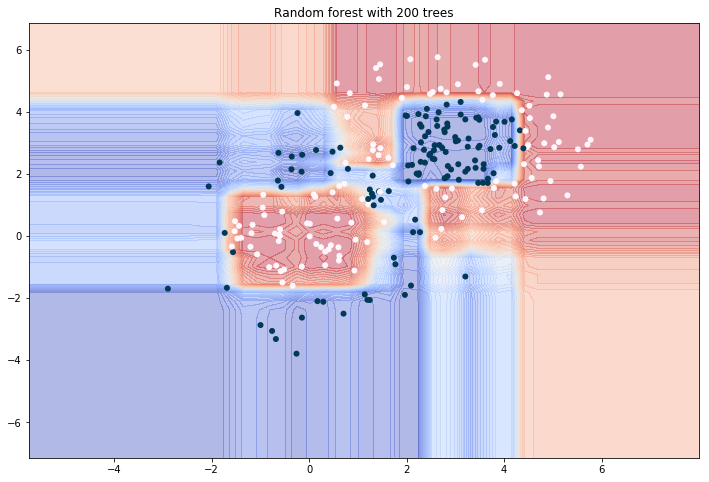

In [28]:
rf200_ = RandomForestClassifier(n_estimators=200, random_state=0x1234)
rf200_.fit(X_train, y_train)

ax = plt.figure(figsize=(12, 8)).add_subplot(111)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
           cmap=plt.cm.PuBu, lw=0, zorder=+99)
prob_ = rf200_.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
ax.contourf(xx, yy, prob_, alpha=0.4, cmap=plt.cm.coolwarm_r,
            levels=np.linspace(0,1, num=51), lw=0)
ax.set_title("Random forest with %d trees"%(rf200_.n_estimators,));

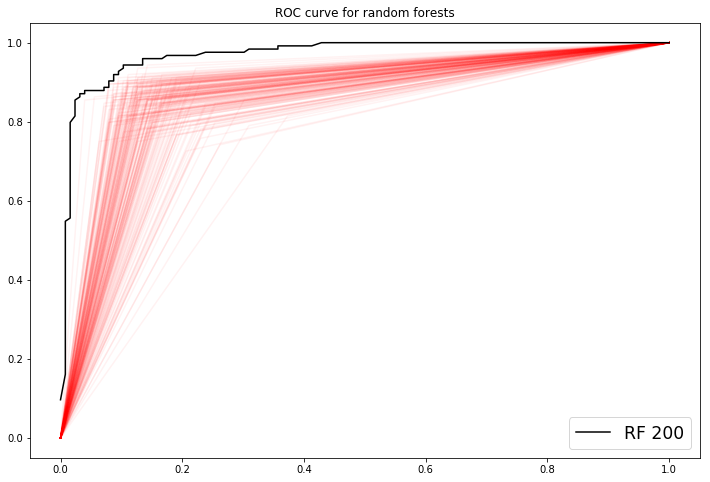

In [29]:
ax = plt.figure(figsize=(12, 8)).add_subplot(111)
for est_ in rf200_.estimators_:
    fpr, tpr, _ = roc_curve(y_test, est_.predict_proba(X_test)[:, 1])
    ax.plot(fpr, tpr, color="red", alpha=0.05)

fpr, tpr, _ = roc_curve(y_test, rf200_.predict_proba(X_test)[:, 1])
ax.plot(fpr, tpr, color="black", label="RF %d"%(rf200_.n_estimators,))

ax.legend(fontsize="xx-large")
ax.set_title("ROC curve for random forests");

### Example

Let's use the [Otto Group Product Classification Challenge](https://www.kaggle.com/c/otto-group-product-classification-challenge)

* multiclass classification problem 
* dataset consists of 93 features with $\approx 61.5k$ observations

[Download the dataset](https://bit.ly/2ljCyNW)

In [30]:
df_train = pd.read_csv(zipfile.ZipFile('train.csv.zip').open('train.csv'), index_col='id')
X = np.asanyarray(df_train.drop('target', axis=1))
y = LabelEncoder().fit_transform(df_train['target'])

Fix the random seed

In [31]:
random_state = np.random.RandomState(seed=0x0BADC0DE)

As usual do the train-test split (and a validation sample).

In [32]:
X_train, X_, y_train, y_ = train_test_split(
    X, y, test_size=0.25,
    random_state=random_state)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_, y_, test_size=0.5, random_state=random_state)

Let's compare the Bagged Decision Tree and the Random Forest

In [33]:
rnd_frs_ = RandomForestClassifier(n_estimators=50)
rnd_frs_.fit(X_train, y_train)

y_predict = rnd_frs_.predict(X_test)
y_score = rnd_frs_.predict_proba(X_test)

rnd_frs_conf_matrix = pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    index=rnd_frs_.classes_,   # actual
    columns=rnd_frs_.classes_  # predicted
)

In [35]:
bag_dtc_full_ = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=50, max_samples=1.0)
bag_dtc_full_.fit(X_train, y_train)

y_predict = bag_dtc_full_.predict(X_test)
y_score = bag_dtc_full_.predict_proba(X_test)

bag_dtc_full_conf_matrix = pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    index=bag_dtc_full_.classes_,   # actual
    columns=bag_dtc_full_.classes_  # predicted
)

In [36]:
bag_dtc_half_ = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=50, max_samples=0.5)
bag_dtc_half_.fit(X_train, y_train)

y_predict = bag_dtc_half_.predict(X_test)
y_score = bag_dtc_half_.predict_proba(X_test)

bag_dtc_half_conf_matrix = pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    index=bag_dtc_half_.classes_,   # actual
    columns=bag_dtc_half_.classes_  # predicted
)

Random forest

In [37]:
rnd_frs_conf_matrix.style.background_gradient(cmap=plt.cm.coolwarm)

Bagged decision tree on full size bootstrap samples

In [38]:
bag_dtc_full_conf_matrix.style.background_gradient(cmap=plt.cm.coolwarm)

Bagged DT classifier on half-size subsamples

In [39]:
bag_dtc_half_conf_matrix.style.background_gradient(cmap=plt.cm.coolwarm)

## Boosting

The underlying idea of boosting is to combine **cheap weak**
predictiors into a strong **powerful ensemble**.


### AdaBoost

This algorithm uses a greedy strategy to construct an additive ensemble of size $T$
from a dictionary of basis predictors.

The size of the ensemble $T$ is a regularization parameter:
* the greater the $T$, the more boosting overfits.

**`AdaBoost.M1(`$S$, $T$, $\mathcal{A}$`)`**:

1. initialize $\omega_{1i} \leftarrow \frac{1}{m}$, $i=1\ldots, m$;
2. for $t=1,\ldots, T$ do:
    1. use $\mathcal{A}$ to fit a classifier $\hat{g}_t$ to $S$ with sample weights $(\omega_{ti})_{i=1}^m$;
    2. get the miscassification error $\epsilon_t = W_t^{-1} \sum_{i\,:\,y_i\neq \hat{g}_t(x_i)} \omega_{ti}$,
    for $W_t = \sum_{i=1}^m \omega_{ti}$;
    3. compute the log-odds ratio $\alpha_t = \log \frac{1-\epsilon_t}{\epsilon_t}$;
    4. update the weights:
    $\omega_{t+1,i} \leftarrow \omega_{ti} \text{exp}\bigl( \alpha_t 1_{\{i\,:\,y_i\neq \hat{g}_t(x_i)\}} \bigr)$;
3. Output the ensemble $\hat{g}(x) = \mathop{\text{sign}}\bigl\{\sum_{t=1}^T \alpha_t \hat{g}_t(x) \bigr\}$;

#### AdaBoost in SciKit

The `ensemble` submodule implements both classification and regression
veriosn of Adaboost
* AdaBoostClassifier -- implements the AdaBoost.M1 algorithm;
* AdaBoostRegressor -- implements the AdaBoost.R2 algorithm;

Algorithms differ only in the **loss** used in determining the weight updates.

In [40]:
from sklearn.ensemble import AdaBoostClassifier, \
                             AdaBoostRegressor

Common parameters:
- **n_estimators** -- the maximum size of the ensemble (in **case of a perfect fit** boosting stops earlier);
- **base_estimator** -- the base estimator of the ensemble, which must support **sample weighting**;
- **learning_rate** -- scales each update, slowing down convergence, but making it more accurate.

AdaBoostClassifier only:
- **algorithm** -- the AdaBoost version to use:
    * _"SAMME"_ -- the SAMME (**M1**) discrete boosting algorithm;
    * _"SAMME.R"_ -- the SAMME.R real boosting algorithm, typically achieves a lower test error with fewer boosting iterations than `SAMME`.

AdaBoostRegressor only:
- **loss** -- the loss function to use when updating the weights after each boosting iteration:
    * _"linear"_ -- absolute loss $L(y, p) = |y-p|$;
    * _"square"_ -- squared loss $L(y, p) = |y-p|^2$;
    * _"exponential"_ -- Exponential loss $L(y, p) = 1-e^{-|y-p|}$.

Produce some toy sample data

In [41]:
X, y = scikit_example(n_samples=500, random_state=random_state)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, random_state=random_state)

min_, max_ = np.min(X, axis=0) - 1, np.max(X, axis=0) + 1
xx, yy = np.meshgrid(np.linspace(min_[0], max_[0], num=51),
                     np.linspace(min_[1], max_[1], num=51))

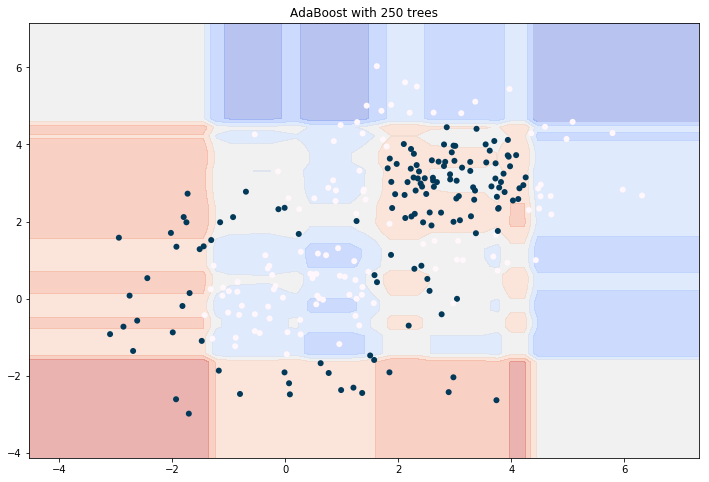

In [42]:
abc1_ = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                          n_estimators=250, random_state=0x1234)
abc1_.fit(X_train, y_train)

ax = plt.figure(figsize=(12, 8)).add_subplot(111)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
           cmap=plt.cm.PuBu, lw=0, zorder=+99)
prob_ = abc1_.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
ax.contourf(xx, yy, prob_, alpha=0.4, cmap=plt.cm.coolwarm, lw=0)
ax.set_title("AdaBoost with %d trees"%(abc1_.n_estimators,));

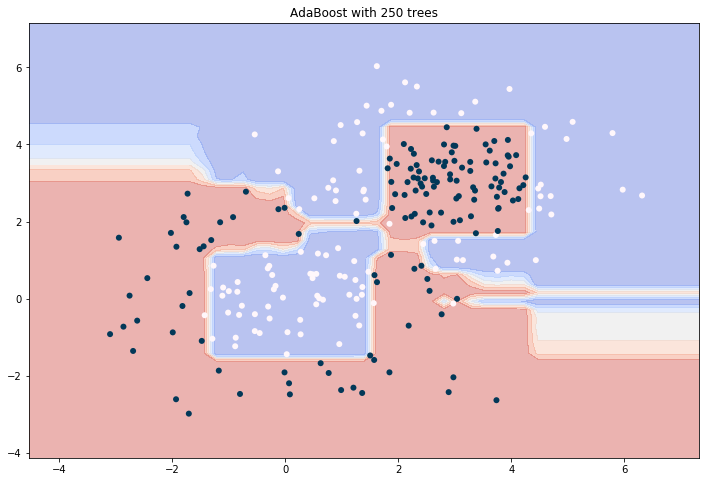

In [43]:
abc4_ = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4),
                          n_estimators=250, random_state=0x1234)
abc4_.fit(X_train, y_train)

ax = plt.figure(figsize=(12, 8)).add_subplot(111)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
           cmap=plt.cm.PuBu, lw=0, zorder=+99)
prob_ = abc4_.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
ax.contourf(xx, yy, prob_, alpha=0.4, cmap=plt.cm.coolwarm, lw=0)
ax.set_title("AdaBoost with %d trees"%(abc4_.n_estimators,));

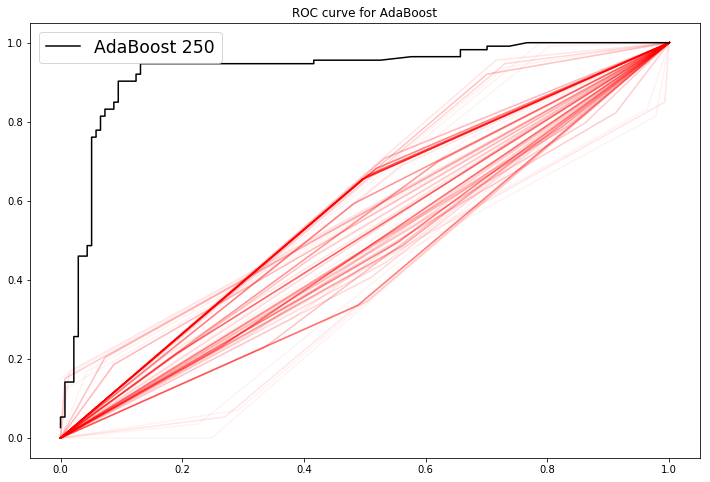

In [44]:
ax = plt.figure(figsize=(12, 8)).add_subplot(111)
for est_ in abc1_.estimators_:
    fpr, tpr, _ = roc_curve(y_test, est_.predict_proba(X_test)[:, 1])
    ax.plot(fpr, tpr, color="red", alpha=0.05)

fpr, tpr, _ = roc_curve(y_test, abc1_.predict_proba(X_test)[:, 1])
ax.plot(fpr, tpr, color="black", label="AdaBoost %d"%(abc1_.n_estimators,))

ax.legend(fontsize="xx-large")
ax.set_title("ROC curve for AdaBoost");

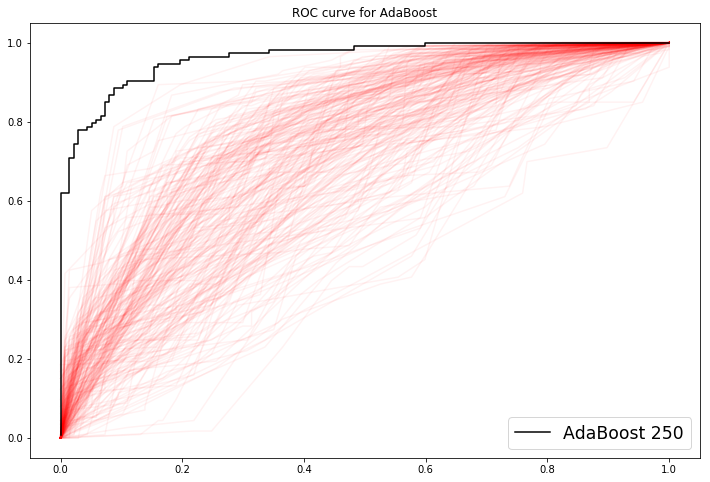

In [45]:
ax = plt.figure(figsize=(12, 8)).add_subplot(111)
for est_ in abc4_.estimators_:
    fpr, tpr, _ = roc_curve(y_test, est_.predict_proba(X_test)[:, 1])
    ax.plot(fpr, tpr, color="red", alpha=0.05)

fpr, tpr, _ = roc_curve(y_test, abc4_.predict_proba(X_test)[:, 1])
ax.plot(fpr, tpr, color="black", label="AdaBoost %d"%(abc4_.n_estimators,))

ax.legend(fontsize="xx-large")
ax.set_title("ROC curve for AdaBoost");

### General Gradient Boosting

General GB allows for the optimization of arbitrary differentiable loss functions.

At each iteration a regression tree is fit on the negative gradient of
the loss function over the data set.

**General Gradient Boosting procedure**
1. Initialize the ensemble with
$f_0 \leftarrow \mathop{\text{argmin}}_\gamma \sum_{i=1}^m L(y_i, \gamma)$;
2. for $t=1,\ldots, T$ do:
    1. Get the loss-minimizing direction $h(\cdot;\theta_t)$ 
    and the optimal stepsize $\gamma_t$ using the **Boosting Core**;
    2. Update the ensemble $f_t = f_{t-1} + \eta \, \gamma_t h(\cdot;\theta_t)$;
3. Return $\hat{f}(x) = f_T(x)$;

Here $\eta$>0 is the learning rate.

### the Boosting Core
The **core** procedure of gradient boosting can be broken into 3 key stages.


`1`. **Descent direction sampling**:

Compute the loss-descent direction on each sample point using the current ensemble:
$$ r_{ti} = \biggl.
        - \frac{\partial}{\partial f(x_i)} L\bigl(y_i, f(x_i)\bigr)
    \biggr\rvert_{f=f_{t-1}}
    \,. $$

Think of $(r_{ti})_{i=1}^m$ a finite-sample approximation of a functional
gradient $\delta \mathcal{L}$ with respect to the predictor.

`2`. **Descent direction generalization**:

Fit a regression function $h(x;\theta)$ to the approximation $(r_{mi})_{i=1}^n$:
$$ (\theta_t, \beta_t)
    \leftarrow \mathop{\text{argmin}}_{\theta, \beta}
        \sum_{i=1}^m \bigl(r_{ti} - \beta h(x_i;\theta) \bigr)^2
    \,.$$

We hope that $h(\cdot;\theta)$:
* approximates the functional gradient well enough on $S$;
* extrapolates beyond the point estimates to their neighbourhoods;

`3`. **Line search**:

Discard $\beta_t$ and determine the optmial `step size` in the direction
of $h(\cdot;\theta_t)$ that minimizes the loss functional itself:
$$ \gamma_t \leftarrow \mathop{\text{argmin}}_\gamma
   \sum_{i=1}^m L\bigl(y_i, f_{t-1}(x_i) + \gamma h(x_i;\theta_t)\bigr)
   \,. $$

### Gradient Boosted Regression Trees

For gradient interpolation one can use:
* regression splines;
* kernel ridge regression;
* regression trees.

GBRT uses regression trees and modifies the **Boosting Core** accoridingly.

Modified core stages:

`2'`. Fit a regression tree $\hat{T}_t = \sum_{j=1}^J \beta_j 1_{R_{tj}}(x)$
    to the current descent direction $(r_{ti})_{i=1}^m$ using a greedy top-down
    recursive partitioning procedure;

`3'`. Determine the optmial leaf weights with respect to the original loss
$$ w_{tj}
    \leftarrow \mathop{\text{argmin}}_w
    \sum_{i\,:\,x_i\in R_{tj}} L\bigl(y_i, f_{t-1}(x_i) + w\bigr)
    \,, $$
where $(R_j)_{j=1}^J$, $J\geq 1$, is the tree-partition of the input space.

### GBRT in Scikit

Scikit offers two Gradient Boosting procedures:
* **`GradientBoostingClassifier`** -- an additive classifying ensemble;
* **`GradientBoostingRegressor`** -- an additive regression ensemble;

In [46]:
from sklearn.ensemble import GradientBoostingClassifier, \
                             GradientBoostingRegressor

- **loss** -- loss function to be optimized:
    * Classification:
        * _'deviance'_ -- refers logistic regression with probabilistic outputs;
        * _'exponential'_ -- gradient boosting recovers the AdaBoost algorithm;
    * Regression:
        * _'ls'_ -- refers to least squares regression;
        * _'lad'_ -- (least absolute deviation) is a highly robust loss function solely
        based on order information of the input variables;
        * _'huber'_ -- is a combination of the two;
        * _'quantile'_ -- allows quantile regression (use `alpha` to specify the
        quantile);

Ensemble parameters:

- **n_estimators** -- The number of boosting stages to perform. Gradient boosting
is fairly robust to over-fitting so a large number usually results in better performance;
- **subsample** -- The fraction of samples to be used for fitting the individual
base learners (choosing `subsample < 1.0` results in Stochastic Gradient Boosting
and leads to a reduction of variance and an increase in bias);
- **max_features** -- The number of features to consider when looking for the
best split: `sqrt`, `log2` and share in $(0,1]$ are accepted (choosing `max_features < n_features`
leads to a reduction of variance and an increase in bias);
- **learning_rate** -- learning rate shrinks the contribution of each tree
by `learning_rate`;

Tree growth parameters:

- **max_depth** -- maximum depth of the individual regression tree estimators (the
maximum depth limits the number of nodes in the tree, the best value depends on the
interaction of the input variables);
- **criterion** -- the criterion to measure the quality of a tree split:
    * _'mse'_ -- the mean squared error;
    * _'friedman__mse'_ -- the MSE with Friedman's improvement score;
    * _'mae'_ -- the Mean Absolute Error;

- ** min_impurity_split** -- Threshold for early stopping in tree growth.
- **min_samples_split** -- The minimum number of samples required to split an
internal node;
- **min_samples_leaf** -- The minimum number of samples required to be at a
leaf node;
- **min_weight_fraction_leaf** -- The minimum weighted fraction of the input
samples required to be at a leaf node;
- **max_leaf_nodes** -- Grow trees with `max_leaf_nodes` in best-first fashion,
with best nodes are defined as relative reduction in impurity.

## XGBoost

a high performance GBRT library, which succeeds in almost every application, especially Kaggle.

* supports many loss functions even non-differentiable
* has $l_1$ and $l_2$ regularization on the leaf-weights
* cost-complexity pruning of the tree induction process
* tree growth with random projections and bagging

XGBoost approximates the loss by a quadratic:
* this increases the ensemble accuracy
* speeds up the convergence

The tree growing procedure uses tree-scores derived from
* the quadratic approximation
* $l_2$ and $l_1$ regularizers
* tree size penalty term

The statges 1-3 of the **Boosting Core** are fused into one in XGBoost.

### Scikit-compatible XGBoost interface

In [47]:
import xgboost as xg

- **objective** -- objective function to run Gradient Boosting on:
    * _"reg:linear"_ -- Linear regression: $(x_i, y_i)_{i=1}^n \in \mathcal{X} \times \mathbb{R}$,
    $\hat{p}:\mathcal{X} \mapsto \mathbb{R}$;
    * _"reg:logistic"_ -- Logistic regression for probability regression task: $(x_i, y_i)_{i=1}^n
    \in \mathcal{X} \times [0, 1]$, $\hat{p}:\mathcal{X} \mapsto [0, 1]$;
    * _"binary:logistic"_ -- Logistic regression for binary classification task: $(x_i, y_i)_{i=1}^n
    \in \mathcal{X} \times \{0, 1\}$, $\hat{p}:\mathcal{X} \mapsto \{0, 1\}$;

- **objective** -- objective function to run Gradient Boosting on:
    * _"binary:logitraw"_ -- Logistic regression for binary classification, output score
    before logistic transformation: $\hat{p}:\mathcal{X} \mapsto \mathbb{R}$;
    * _"multi:softmax"_ -- Softmax for multi-class classification, output class index:
    $\hat{p}:\mathcal{X} \mapsto \{1,\ldots,K\}$;
    * _"multi:softprob"_ -- Softmax for multi-class classification, output probability
    distribution:  $\hat{p}:\mathcal{X} \mapsto \{\omega\in [0,1]^K\,:\, \sum_{k=1}^K \omega_k = 1 \}$;

GB ensemble parameters:

- **eta**, **learning_rate** ($\eta$) -- step size scaling
- **n_estimators**, **num_boost_round** ($T$) -- the size of the ensemble, number of boosting rounds
- **base_score** -- global bias of the model:
    * linear regression ("reg:linear") sets the intercept of the regression function
    * binary classification ("reg:logistic", "binary:logistic" and "binary:logitraw")
    sets the base class ratio.

Tree growth and decorrelation:
- **max_depth** -- a hard bound on the number of tree layers
- **min_child_weight** -- the minimal value of the hessian statistic of a leaf
required for it to be considered a candidate for splitting
- **gamma** ($\gamma$) -- the minimal structural score gain for splitting a leaf of the currnt tree

- **subsample** -- the size bootstrap smaples $S^{*b}$
- **colsample_bytree** -- the size of the random subset of features allowed for use
during the growth of the **whole** tree
- **colsample_bylevel** -- the size of the subsample of features to consider when
making a split at each level of every tree

Tree leaf weights:
- **reg_alpha** ($\alpha$) -- the weight of the $l_1$ regularizer;
- **reg_lambda** ($\lambda$) -- the cost of the $l_2$ regularization term;
- **max_delta_step** -- clips the absolute value of each leaf's score,
making the growth steps more conservative.

Early-stopping
- **early_stopping_rounds** -- the validation error on the last validation dataset needs
to decrease at least every `early_stopping_rounds` round(s) to continue training
- **eval_set** -- validation datasets given as a list of tuples (DMatrix, name)

Create the xgboost classifier instance for the multiclass problem

As usual do the train-test split (and a validation sample).

In [54]:
df_train = pd.read_csv(zipfile.ZipFile('train.csv.zip').open('train.csv'), index_col='id')
X = np.asanyarray(df_train.drop('target', axis=1))
y = LabelEncoder().fit_transform(df_train['target'])

X_train, X_, y_train, y_ = train_test_split(
    X, y, test_size=0.25,
    random_state=random_state)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_, y_, test_size=0.5, random_state=random_state)

In [55]:
xgb_ = xg.XGBClassifier(
## GBT procedure parameters
    n_estimators=50,
    learning_rate=0.1,
    objective="multi:softmax",
    base_score=0.5,

## Tree growth
    max_depth=6,
    gamma=0.5,
    min_child_weight=1.0,
    max_delta_step=0.0,
    subsample=1.0,
    colsample_bytree=1.0,
    colsample_bylevel=1.0,

## Service parameters
    nthread=4, silent=True, seed=123)

In [56]:
xgb_.fit(X_train, y_train, eval_set=[(X_valid, y_valid),], verbose=False);

y_predict, y_score = xgb_.predict(X_test), xgb_.predict_proba(X_test)
xgb_conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_predict),
                               index=xgb_.classes_,
                               columns=xgb_.classes_)

Let's see how well it performs on the test dataset

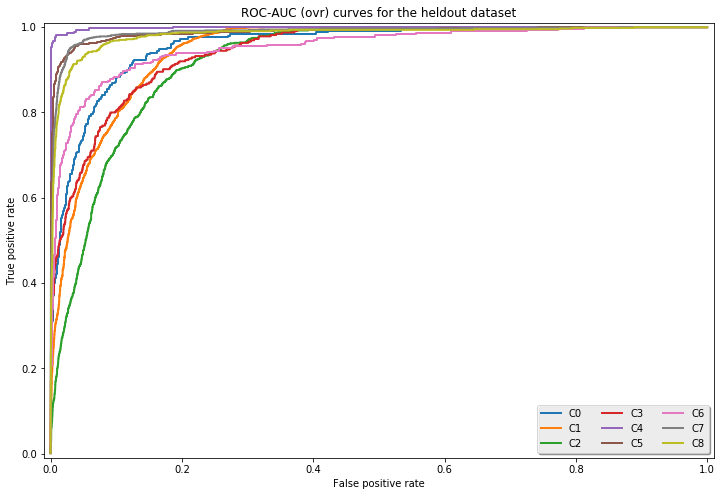

In [57]:
ax = plt.figure(figsize=(12, 8)).add_subplot(111)
ax.set_title("ROC-AUC (ovr) curves for the heldout dataset")
ax.set_xlabel("False positive rate"); ax.set_ylabel("True positive rate")
ax.set_ylim(-0.01, 1.01); ax.set_xlim(-0.01, 1.01)
for cls_ in xgb_.classes_:
    fpr, tpr, _ = roc_curve(y_test, y_score[:, cls_], pos_label=cls_)
    ax.plot(fpr, tpr, lw=2, zorder=cls_, label="C%d" % (cls_,))
ax.legend(loc='lower right', shadow=True, ncol=3);

Let's see how AdaBoost Compares to XGBoost

In [58]:
abc_ = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6),
                          n_estimators=50,
                          learning_rate=0.1,
                          random_state=123)
abc_.fit(X_train, y_train)

y_predict, y_score = abc_.predict(X_test), abc_.predict_proba(X_test)
abc_conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_predict),
                               index=abc_.classes_,
                               columns=abc_.classes_)

In [59]:
xgb_conf_matrix.style.background_gradient(cmap=plt.cm.coolwarm)

In [60]:
abc_conf_matrix.style.background_gradient(cmap=plt.cm.coolwarm)